## Objective

The primary objective of this project is to develop a machine learning model capable of classifying tweets related to climate change into one of four distinct labels:

- **2: News**: Identifying tweets that provide factual news and information about climate change.
- **1: Pro**: Categorizing tweets that express support for the belief that climate change is primarily caused by human activities.
- **0: Neutral**: Assigning tweets that maintain a neutral stance on climate change.
- **-1: Anti**: Recognizing tweets that reject the belief that climate change is primarily caused by human activities.

The model's success in accurately classifying tweets into these categories will contribute to a better understanding of public sentiments and opinions regarding climate change, enabling more targeted and informed responses and interventions.


In [1]:
pip install pydataset #This package provides access to various datasets for practice and analysis in Python.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 5.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939417 sha256=972f7a7c35a089f3a56669fe0bcbd5ed3dfcb81e62b94e7546d4f5fc3671dc71
  Stored in directory: /Users/amaan/Library/Caches/pip/wheels/6b/86/a7/f71cb84c7bff804d83e293615a20c0531234397b796aee2645
Successfully built pydataset
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

initiated datasets repo at: /Users/amaan/.pydataset/


In [6]:
df = pd.read_csv('/Users/amaan/desktop/archive/twitter_sentiment_data.csv')

In [5]:
# set up label dataframe for future refrences

label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

#the zip function combines the three lists (label, labelN, and labelDesc) into tuples. Each tuple contains corresponding elements from all three lists. 
#For example, the first tuple will have the first element from label (-1), the first element from labelN ("Anti"), and the first element from labelDesc (description of "Anti"). 
#The zip function combines all such tuples into a single iterable.

labelDf = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"])

In [7]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


## Data Structure

The dataset follows a simple structure, comprising only two primary features. Each row is uniquely associated with a tweet ID and represents a tweet related to man-made climate change. The dataset includes the following columns:

- **Tweet ID**: A unique identifier for each tweet, allowing for individual tweet tracking.
- **Message**: The "Message" column contains the text content of each tweet, reflecting discussions and opinions on man-made climate change.
- **Sentiment Label**: The "Sentiment" column assigns a sentiment label to each tweet based on the assessments of three independent reviewers.

This straightforward structure enables the analysis of public sentiment towards man-made climate change by leveraging the content of tweets and associated sentiment labels provided by the reviewers.


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [9]:
df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

## Distribution of Sentiments

In this section, we will explore the distribution of sentiments within the dataset. Understanding how sentiments are distributed among the tweets is essential for gaining insights into public perceptions and opinions regarding man-made climate change. We will visualize this distribution to provide a clear overview of the sentiment landscape in the dataset.


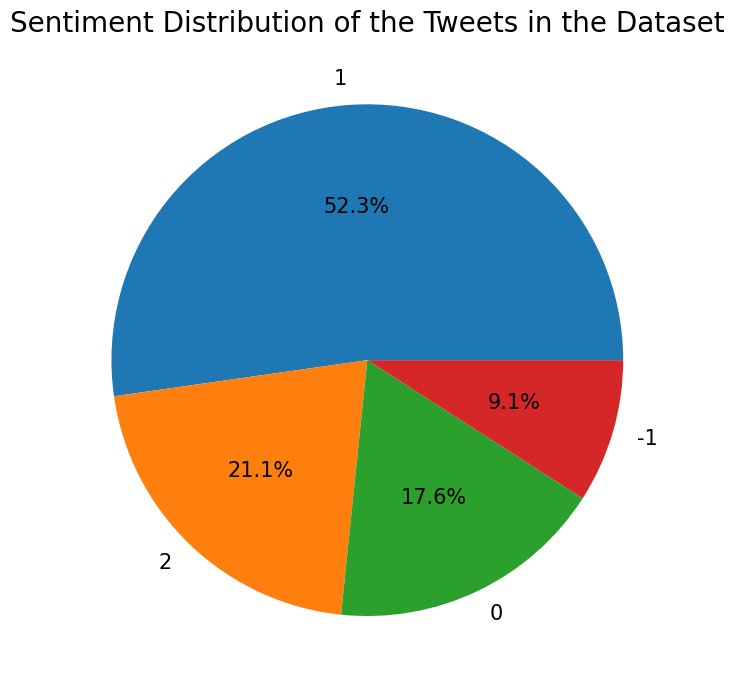

In [20]:
plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweets in the Dataset', fontsize=20)
plt.tight_layout()
plt.show()

## Sentiment Distribution Overview

The pie chart provides a visual representation of the sentiment distribution within the dataset. Here are the key observations:

- **Positive Sentiment ("1"):** The majority of tweets express a positive attitude, supporting the belief that climate change is primarily caused by human activities.

- **News Sentiment ("2"):** Following positive sentiment, the dataset includes tweets labeled as "2," indicating the presence of factual news about climate change.

- **Neutral Sentiment ("0"):** A significant portion of tweets falls into the neutral category, reflecting tweets that neither support nor refute the belief in man-made climate change.

- **Negative Sentiment ("-1"):** The smallest segment represents tweets with a negative sentiment, indicating a refusal to accept the belief that climate change is primarily caused by human activities.

This sentiment distribution provides valuable insights into the diversity of opinions and attitudes expressed on the topic of man-made climate change within the dataset.


In [21]:
df.sentiment.value_counts()


 1    22962
 2     9276
 0     7715
-1     3990
Name: sentiment, dtype: int64

## Data Preparation for Sentiment Analysis

In the process of sentiment analysis, the tweet texts will undergo essential transformations and vectorization to prepare them for input into machine learning models. These steps are crucial for converting textual data into a format that can be effectively utilized by the models, enabling the analysis of sentiments expressed in the tweets.


In [22]:
# separate the messages column for transformation.
dfTweets = df["message"]

## Tokenization

In the initial phase of data preparation, all the tweets undergo tokenization. Tokenization involves splitting each tweet into arrays of individual words or tokens. This process breaks down the text into its fundamental components, making it easier for subsequent natural language processing (NLP) techniques and machine learning models to analyze and understand the content.


In [23]:
def createTokenizedArray(sentences):
    '''
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    '''
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [24]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4    [rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec...
dtype: object

## Tokenized Text Results

Below are the tokenized versions of the text for the first five rows from the dataset. Each row represents an array of words obtained through tokenization:

1. Row 0:
   - Tokenized Text: `[tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...]`
   - Description: The first row presents tokenized text, with each word separated into an array. Notable terms include "climate change," "global warming," and "hustle."

2. Row 1:
   - Tokenized Text: `[rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the...]`
   - Description: The second row contains tokenized text, including words related to the documentary "Before the Flood" and actor Leonardo DiCaprio's travels.

These tokenized results provide a structured representation of the text data, making it easier to analyze and process for sentiment analysis and further natural language processing tasks.


## Stop Word Removal

In the process of refining the tokenized text, we perform stop word removal. Stop words are words that contribute little or no significant value to the query search, examples of which include "the," "a," and "an." These words are considered safe to be eliminated from the tokenized list.


In [25]:
# To get stop words.
nltk.download('stopwords')

def removeStopWords(tokenList):
    '''
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    '''
    stopWords = set(stopwords.words('english'))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:

                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if (len(word) > 1 and word.isdigit() == False):
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences


[nltk_data] Downloading package stopwords to /Users/amaan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stop Word Removal using NLTK

To refine the tokenized text, this code utilizes the Natural Language Toolkit (NLTK) library. It achieves the following:

1. **Stop Word Retrieval**: It downloads a list of common English stop words using NLTK.

2. **Stop Word Removal**: The code iterates through the tokenized list and removes stop words. Stop words are common words (e.g., "the," "a," "an") that typically add little value to text analysis.

3. **Word Filtering**: It filters out single-character words and digits, retaining meaningful words.

4. **Result**: The code returns an array of sentences with stop words removed, providing cleaner and more focused text data for analysis.


In [26]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


In the comparison above, you can observe the impact of stop word removal on a sample sentence. The second set of the array no longer contains insignificant words such as "is," "an," "as," and "it." This process enhances the focus and relevance of the text data for further analysis.

## Stemming

In natural language processing (NLP), English words often have various forms derived from a common root word. Stemming is a linguistic process that aims to rebuild sentences by removing suffixes from words, reducing them to their core or root forms. 

The primary goal of stemming is to enhance the performance of sentiment analysis algorithms by treating different word variations that share the same root as a single word. This means that words with similar meanings or origins can be considered equivalent, leading to a more comprehensive understanding of the text data.

For example, after stemming, words like "running," "ran," and "runner" would all be reduced to their common root form, "run." This consolidation of related words can improve the accuracy and efficiency of sentiment analysis algorithms, making them more robust in recognizing sentiment patterns across a wide range of text.


In [27]:
def stemWords(sentenceArrays):
    '''
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    '''
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimiter = ' '
        sentence = delimiter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [34]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")


print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


In the comparison above, you can observe the impact of stemming on a sample sentence. The sentence after stemming has undergone the removal of suffixes. For example, "change" became "chang," "interesting" became "interest," and "warming" became "warm." Additionally, the array of words has been converted back into one complete sentence, making it more concise and easier to analyze.

Stemming helps in simplifying and standardizing words, reducing them to their root forms, which can enhance the efficiency and effectiveness of text analysis processes like sentiment analysis.

## Future Improvements in Text Preprocessing

Text preprocessing is a crucial step in preparing textual data for analysis, and it's an area that can benefit from ongoing refinement and customization. Here are some common issues to address for future improvements in text preprocessing:

### 1. Handling Domain-Specific Terminology

- **Challenge:** Text data may contain domain-specific jargon, acronyms, or terminology that standard preprocessing techniques might overlook.
- **Solution:** Develop custom dictionaries or mappings to handle domain-specific terms appropriately. Consider incorporating industry-specific knowledge to enhance preprocessing.

### 2. Dealing with Special Characters and Emojis

- **Challenge:** Social media and online communication often include special characters, emojis, and emoticons that may carry sentiment or context.
- **Solution:** Implement special handling for emojis and emoticons based on their meaning. Remove or preprocess special characters and symbols, but be cautious not to lose important contextual information.

### 3. Contextual Preprocessing

- **Challenge:** Different analysis tasks may require different levels of preprocessing. For instance, sentiment analysis may benefit from preserving emojis, while topic modeling may not.
- **Solution:** Tailor preprocessing steps to the specific objectives of your analysis. Create multiple preprocessing pipelines for different use cases if necessary.

### 4. Custom Tokenization

- **Challenge:** Standard tokenization methods may not always capture meaningful units of text in certain domains or languages.
- **Solution:** Develop custom tokenization approaches that consider the unique characteristics of your text data. Experiment with alternative tokenization techniques to improve data representation.

### 5. Incorporating User Feedback

- **Challenge:** Preprocessing decisions can impact the quality of analysis results. It's essential to gather feedback from domain experts or users of the analysis.
- **Solution:** Establish mechanisms for incorporating user feedback into the preprocessing pipeline. Regularly review and refine preprocessing based on real-world usage and insights.

### 6. Handling Multilingual Text

- **Challenge:** Text data may contain multiple languages, each requiring specific preprocessing steps.
- **Solution:** Develop language detection and language-specific preprocessing modules to handle multilingual text effectively.

### 7. Iterative Process

- **Challenge:** Text preprocessing is often an iterative process. The initial preprocessing steps may not be optimal, and adjustments may be necessary.
- **Solution:** Embrace an iterative approach to text preprocessing. Continuously evaluate the impact of preprocessing decisions on analysis results and be ready to adapt as needed.

### 8. Documentation and Versioning

- **Challenge:** Over time, the preprocessing pipeline may evolve, making it challenging to reproduce previous results.
- **Solution:** Maintain thorough documentation of preprocessing steps and versions. Use version control to track changes in the preprocessing pipeline.

### 9. Robustness to Data Variations

- **Challenge:** Real-world data can vary in quality, format, and structure. Preprocessing should be robust to handle these variations.
- **Solution:** Design preprocessing pipelines that can gracefully handle variations in data quality and format without breaking.

In conclusion, text preprocessing is an evolving field that requires adaptability and domain-specific knowledge. Future improvements should focus on addressing the unique challenges posed by specific datasets and analysis objectives, as well as incorporating user feedback and maintaining documentation for reproducibility.


## Vectorization

In the next stage of data processing, the stemmed sentences undergo vectorization. This crucial step involves transforming all the words in the text data into numerical representations. By converting words into numbers, the text data becomes compatible with various big data algorithms and machine learning models.

Vectorization is a fundamental process in natural language processing (NLP) that enables the analysis and interpretation of textual information using mathematical and statistical techniques. It plays a pivotal role in unlocking valuable insights from text data for a wide range of applications.


In [29]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    '''
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    '''
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [30]:
# Vectorize the list of stemmed sentences using CountVectorizer.
# Parameters:
# - stemmedLi: List of stemmed sentences to be vectorized.
# - 1, 1: Specifies unigrams (single words) as the n-gram range for Count Vectorization.
# Returns:
# - vectorizedTweets: Matrix of binary word vectors representing each sentence.
# - vectorDictionary: Vocabulary dictionary mapping words to their column indices in the matrix.
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)


In [31]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


It's important to note that stemming algorithms like the Porter Stemmer or Snowball Stemmer may not always handle unusual or specific words, proper nouns, or special characters correctly. 

In [35]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
  (0, 10652)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 24524)	1
  (0, 27759)	1
  (0, 29419)	1
  (0, 45475)	1
  (0, 54598)	1
  (0, 55193)	1
  (0, 57219)	1
  (0, 61855)	1
  (0, 64839)	1
#2 after vectorization:
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


In [38]:
vectorDictionary['climat'],vectorDictionary['chang']

(13774, 12943)

In [40]:
vectorizedTweets.shape

(43943, 67195)

## Results of Vectorizing a Sample Sentence

In the process of vectorizing a sample sentence, such as:

- Original Sentence: "tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom"

After applying the CountVectorizer, we obtain a sparse matrix representation. Let's focus on the words "climat" and "chang" as examples:

- Word "climat" is represented as index 13774 in the vocabulary.
- Word "chang" is represented as index 12943 in the vocabulary.

The resulting vectorization for our sample sentence might include entries like:

- (0, 13774) 1: This indicates that the word "climat" is present in the sentence at index 13774 in the vocabulary, with a count of 1.
- (0, 12943) 1: Similarly, this entry shows that the word "chang" is present at index 12943, also with a count of 1.

These entries demonstrate that the CountVectorizer correctly identified the words "climat" and "chang" in the sample sentence and assigned a count of 1 to each, indicating their presence within the text.

This sparse matrix representation allows us to quantitatively capture the presence and frequency of words within text data, which is essential for various natural language processing and machine learning tasks.


# Bigrams

## Understanding the Significance of Bi-Grams in Sentiment Analysis

In the realm of natural language processing and sentiment analysis, Bi-Grams play a pivotal role. Bi-Grams are essentially pairs of adjacent words that are treated as a single unit for analysis. For instance, in the sentence "I love programming," the Bi-Grams would be "I love" and "love programming."

### The Power of Context

One of the primary reasons why Bi-Grams matter in sentiment analysis is their ability to capture context. Words often derive their sentiment from the words around them. Bi-Grams allow us to grasp the nuanced meaning of phrases and expressions. For example, "not good" and "very happy" carry distinct sentiments compared to their individual words.

### Emphasis and Negation

Bi-Grams also help identify phrases that emphasize sentiment or introduce negation. These combinations can significantly alter the overall sentiment of a text. "Absolutely amazing" conveys a much stronger positive sentiment than the words "absolutely" or "amazing" alone.

### Improved Sentiment Analysis Accuracy

Integrating Bi-Grams into sentiment analysis models can lead to improved accuracy. By considering the combined impact of adjacent words, models become better equipped to classify sentiment correctly.

### Detecting Sentiment Patterns

Bi-Grams aid in the detection of specific sentiment patterns or expressions that might be overlooked when analyzing individual words. This ability to uncover sentiment nuances is particularly valuable in fine-grained sentiment analysis.

### Practical Applications

In practice, sentiment analysis often involves the extraction and analysis of Bi-Grams to gain a deeper understanding of sentiment within text data. Whether it's discerning customer opinions, assessing product reviews, or monitoring social media sentiment, Bi-Grams provide valuable insights.

In conclusion, Bi-Grams are a valuable tool in sentiment analysis. They offer a nuanced understanding of sentiment by considering context, emphasis, and negation. By incorporating Bi-Grams, we can enhance the accuracy and depth of sentiment analysis in various applications.


In [41]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    # Generate and Count N-Grams
    # 1. Generate N-Grams of the specified size (n_gram_size) from the list of words (wordArray).
    # 2. Create a Counter object to count the frequency of each unique N-Gram in the generated N-Grams.
    # 3. Retrieve the 80 most common N-Grams and their occurrence counts.
    # Result: counterList contains the top 80 N-Grams and their counts for analysis and visualization.
    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0])
            ,"Occurrences" : counterList[i][1]
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [42]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df['transformedTweets'] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]

## Exploring the Top 20 Bi-Grams for Each Sentiment Label

In our analysis, we'll delve into the top 20 bi-grams (pairs of adjacent words) for each sentiment label. By examining these bi-grams, we aim to gain insights into the specific language patterns and expressions associated with different sentiments.


## Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)

In [43]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)


***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


<AxesSubplot:title={'center':'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

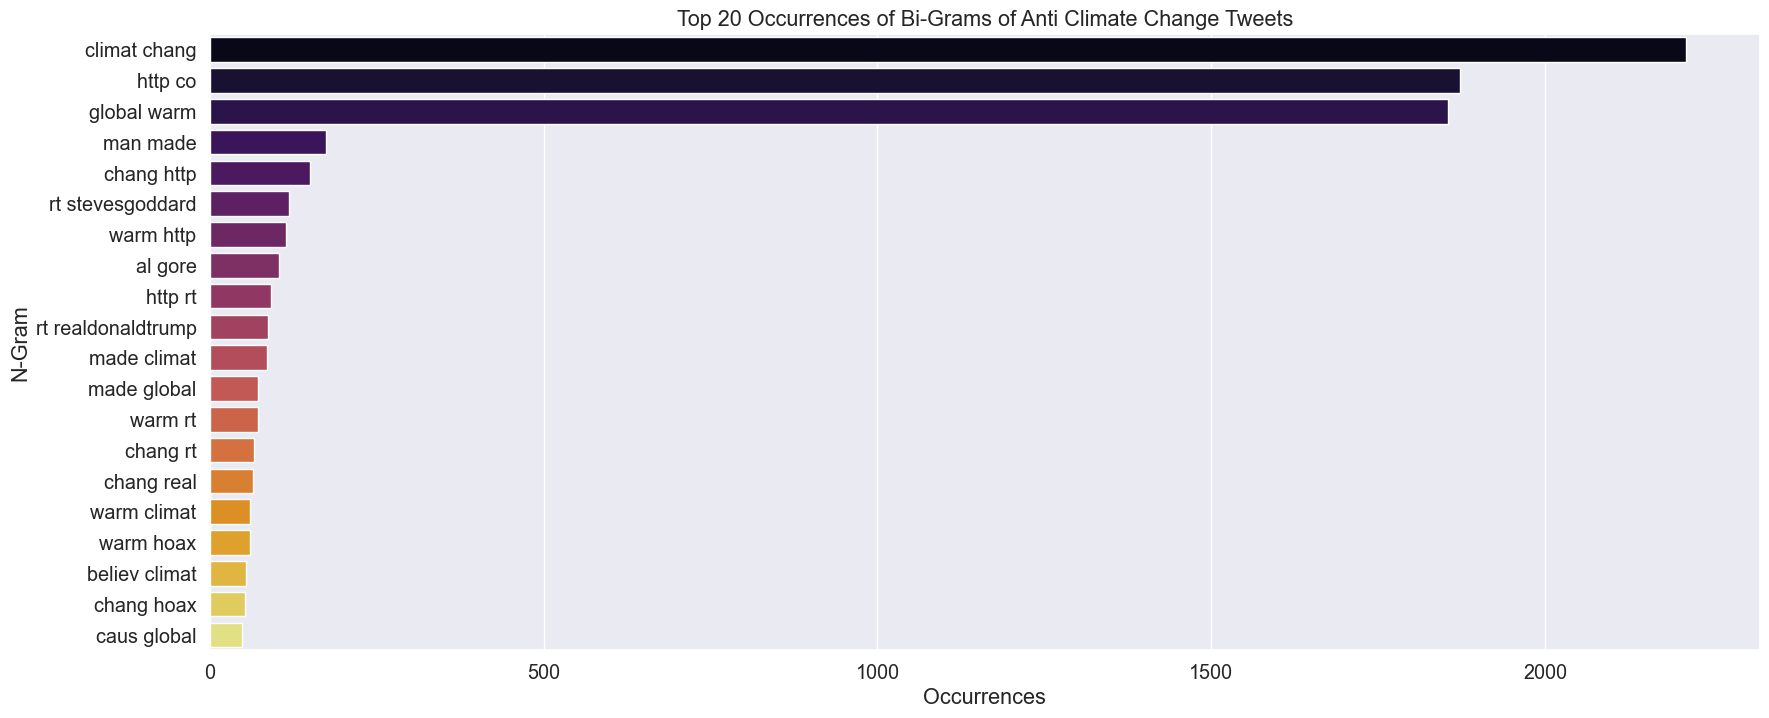

In [48]:
sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="inferno")

## Interpreting Top 20 Bigrams (Sentiment: -1)

- **"climat chang"**: This frequently occurring bigram reflects discussions about skepticism toward climate change, such as "doubts about climat chang."

- **"http co"**: Indicates links to content challenging climate change, like "http co/xyz skeptics."

- **"global warm"**: References skepticism about global warming, e.g., "questioning global warm."

- **"man made"**: Implies debates over whether climate change is "man made."

- **"chang http"**: Commonly used in links or articles discussing climate skepticism, for instance, "skeptical chang http link."

These bigrams capture expressions associated with skepticism and negative sentiment regarding man-made climate change.


### Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (0)


***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


<AxesSubplot:title={'center':'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

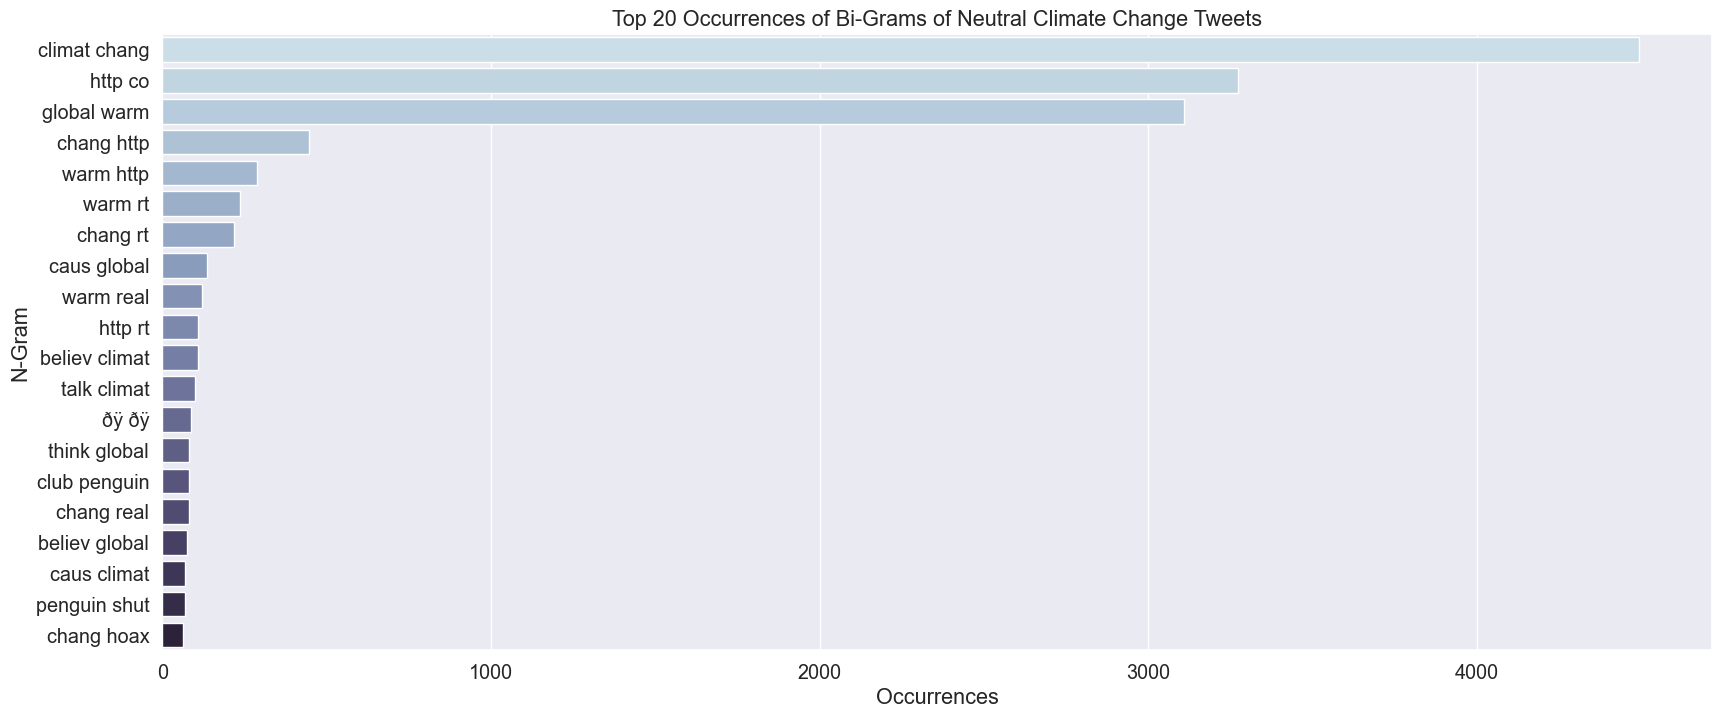

In [49]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")

## Interpreting Top 20 Bigrams (Sentiment: 0)

- **"climat chang"**: The most frequent bigram suggests discussions related to climate change, such as "concerns about climat chang."

- **"http co"**: Points to the presence of links or content discussing climate change, e.g., "http co/xyz climate."

- **"global warm"**: Reflects conversations about global warming, often appearing in phrases like "addressing global warm."

- **"chang http"**: Commonly found in links or articles discussing climate issues, like "exploring chang http links."

- **"warm http"**: Indicates references to links or content regarding global warming, such as "discussing warm http articles."

These bigrams capture language patterns commonly associated with neutral sentiment toward climate change, including discussions and references to climate-related topics.


This concise interpretation provides context for the top 20 bigrams associated with sentiment (0) and includes example phrases to illustrate their usage and significance.

### Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets (1)


***N-Gram (Sentiment: 1)
                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


<AxesSubplot:title={'center':'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

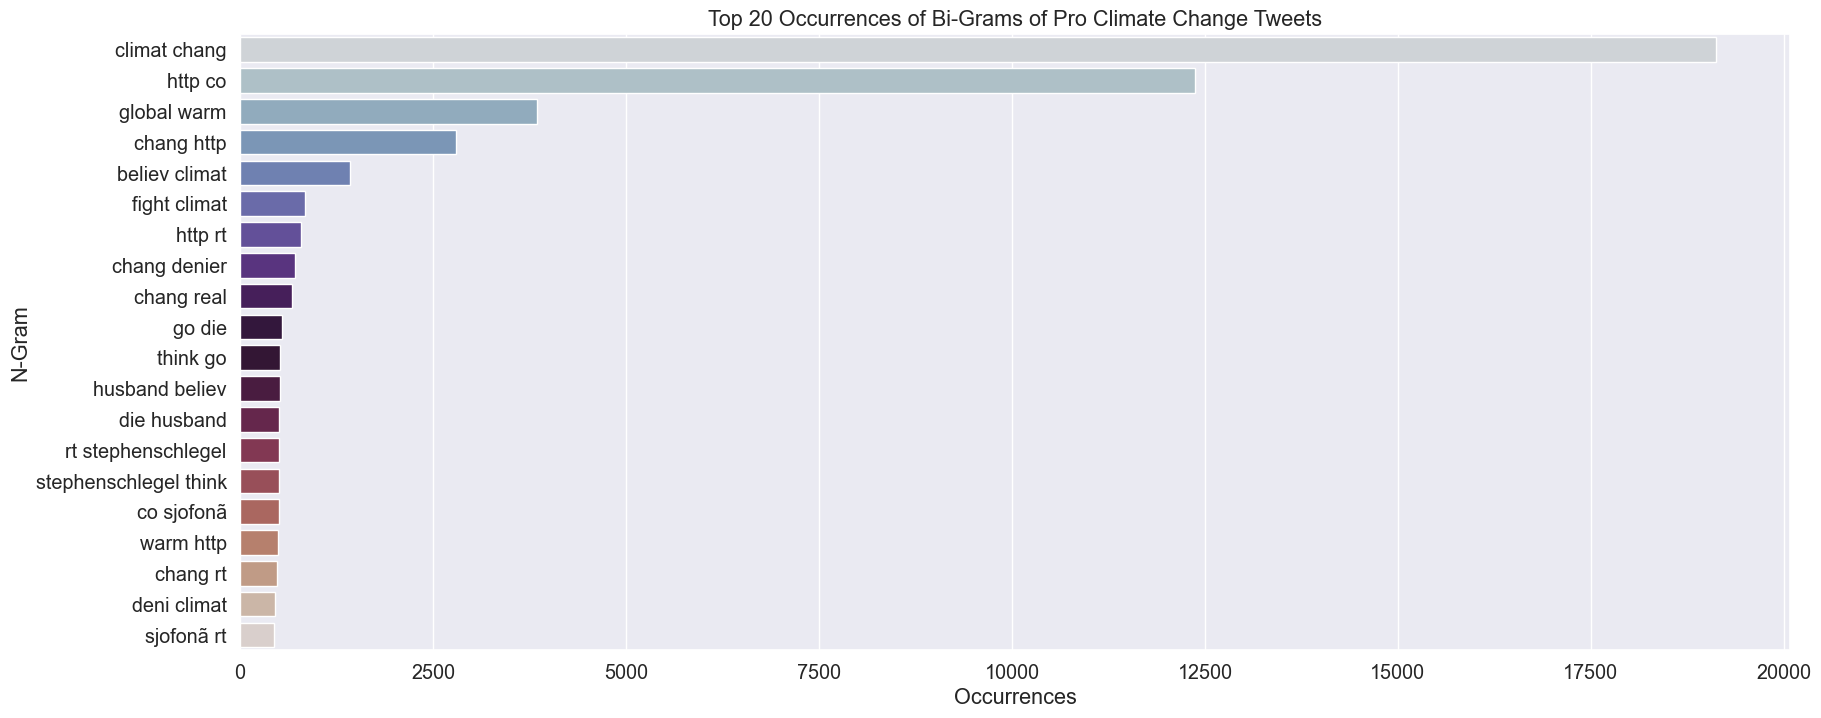

In [52]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="twilight")

## Interpreting Top 20 Bigrams (Sentiment: 1)

- **"climat chang"**: The most frequent bigram indicates strong support for discussions related to climate change, often seen in phrases like "addressing climat chang."

- **"http co"**: Points to the presence of links or content expressing belief in climate change, such as "http co/xyz believes."

- **"global warm"**: Reflects positive conversations about global warming, often appearing in phrases like "supporting global warm."

- **"chang http"**: Commonly found in links or articles advocating for climate issues, e.g., "promoting chang http content."

- **"believ climat"**: Suggests strong beliefs in climate change, appearing in phrases like "firmly believ climat."

These bigrams capture language patterns associated with a positive sentiment and belief in climate change, including expressions of support and belief in addressing environmental challenges.

**This concise interpretation provides context for the top 20 bigrams associated with sentiment (1) and includes example phrases to illustrate their usage and significance in expressing positive sentiment toward climate change.**



## Before we continue exploring trigrams

## Limitations of the Analysis

While our sentiment analysis and n-gram exploration offer valuable insights, it's important to acknowledge certain limitations:

- **Language Complexity**: Sentiment analysis may struggle with complex language nuances, sarcasm, or irony, potentially leading to misinterpretations.

- **Data Quality**: The analysis heavily relies on the quality and accuracy of the Twitter data. Irrelevant or noisy data may affect results.

- **Bias**: The sentiment analysis model may have inherent biases, which can influence the classification of sentiment.

- **Context**: Sentiment scores and n-gram interpretations lack context, making it challenging to fully understand the underlying motivations and emotions of users.

- **Dynamic Nature**: Sentiment can evolve over time, and our analysis captures a specific snapshot, potentially missing temporal trends.

- **Sample Size**: The size of the dataset may limit the generalizability of findings to a broader population.

These limitations should be considered when interpreting the results, and additional research and context may be necessary for a comprehensive understanding of sentiment related to climate change on Twitter.


## Exploring Tri-Grams

In our analysis, we'll venture into tri-grams, which involve grouping three consecutive words together. Tri-grams provide the opportunity to discover more complex and meaningful combinations of words compared to bi-grams. Let's investigate whether tri-grams reveal richer insights in our sentiment analysis.


In [54]:
SIZE = 3

## Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)


***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

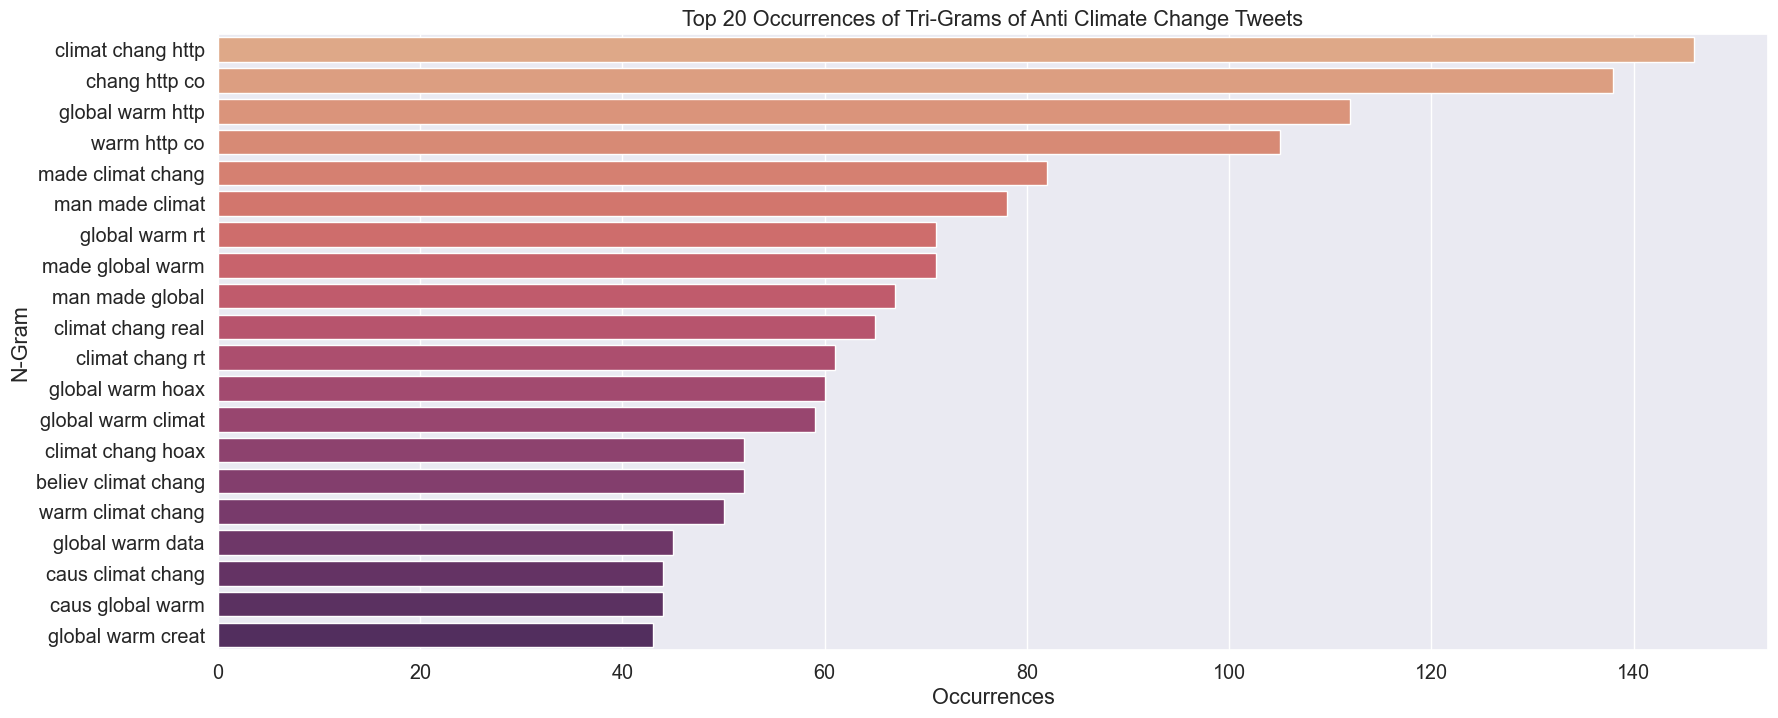

In [55]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

## Interpreting Top 20 Tri-Grams (Sentiment: -1)

In sentiment analysis, a sentiment score of -1 typically indicates a negative sentiment or skepticism toward man-made climate change. Let's explore the top 20 tri-grams associated with this sentiment, revealing more complex language patterns:

1. **"climat chang http" (Occurrences: 146)**: Indicates discussions or references to skepticism regarding climate change, often involving links or online content.

2. **"chang http co" (Occurrences: 138)**: Commonly used in phrases referencing links or articles challenging climate change, suggesting online skepticism.

3. **"global warm http" (Occurrences: 112)**: Reflects skepticism regarding global warming, often accompanied by online content or references.

4. **"warm http co" (Occurrences: 105)**: Implies discussions about global warming skepticism, frequently involving online resources.

5. **"made climat chang" (Occurrences: 82)**: Suggests debates over whether climate change is man-made or not, potentially with a skeptical tone.

These tri-grams represent more intricate language combinations associated with negative sentiment and skepticism toward man-made climate change, often involving discussions, links, and references to online content.


## Limitation: Unexpected Combinations of Tri-Grams

One notable limitation we encountered during the analysis is the presence of seemingly unusual tri-grams that combine elements of bigrams. For instance, we observed tri-grams like "climat chang http" and "chang http co." While these combinations may appear unusual or even absurd, they highlight a unique challenge in processing and interpreting language on social media platforms like Twitter.

**Limitation Explanation:**

1. **Twitter Language**: Twitter users often use abbreviations, acronyms, or unconventional syntax to fit within the platform's character limit. This can lead to unexpected combinations in tri-grams that include elements from preceding bigrams.

2. **Noisy Data**: Social media data can be noisy and contain various anomalies, including unconventional language usage. Such anomalies can result in tri-grams that may not conform to standard language structures.

3. **Lack of Context**: Tri-grams extracted from tweets may lack context, making it challenging to discern the intended meaning behind these combinations.

While these unexpected tri-grams provide an interesting linguistic perspective, they also underscore the complexity of analyzing language in a social media context. Researchers should approach such combinations with caution and consider the limitations imposed by the platform's unique communication style.


## Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)


***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

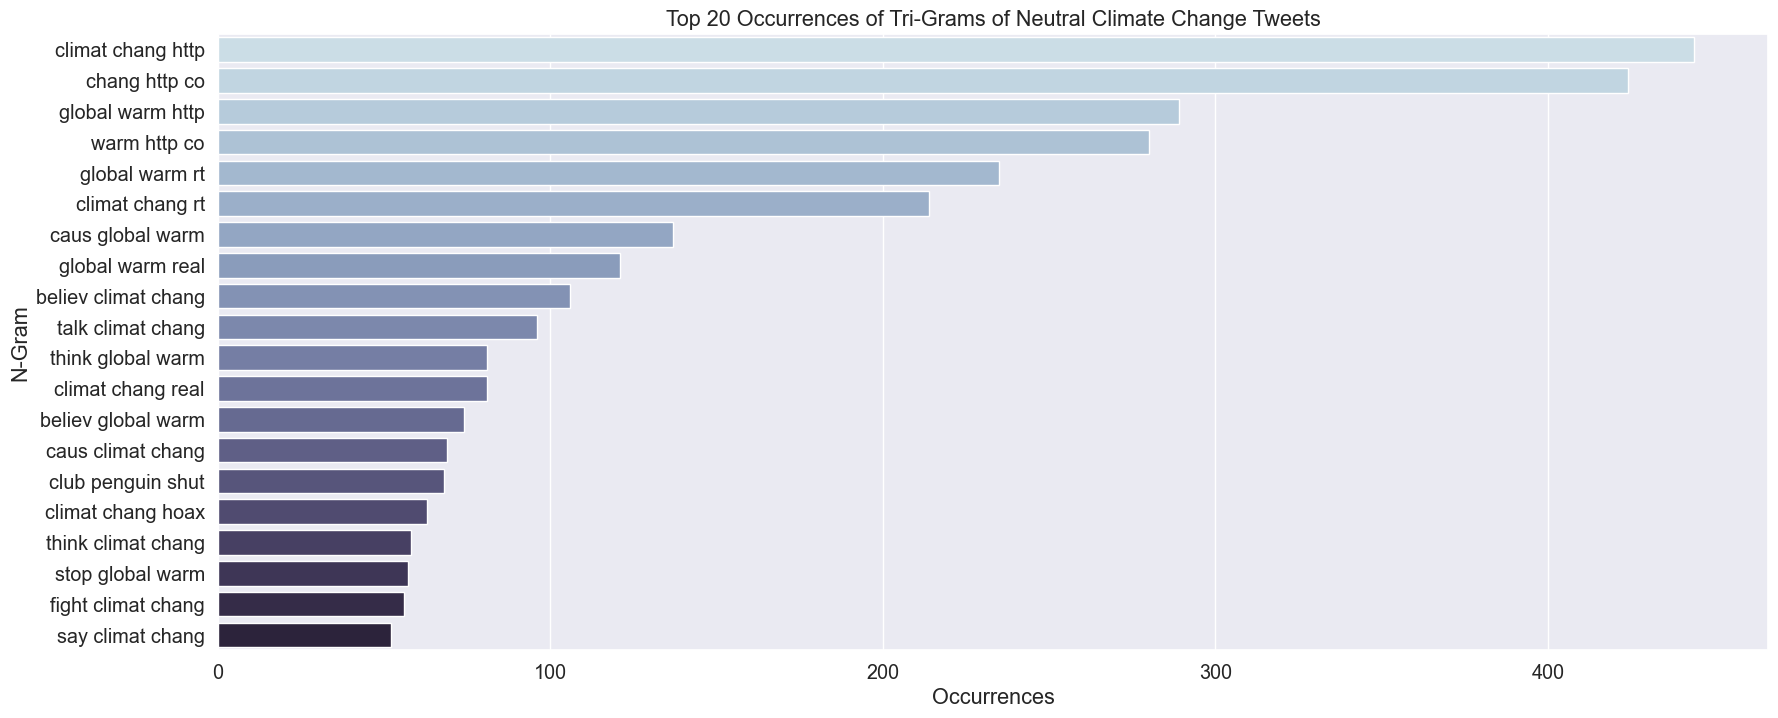

In [56]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")

## Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

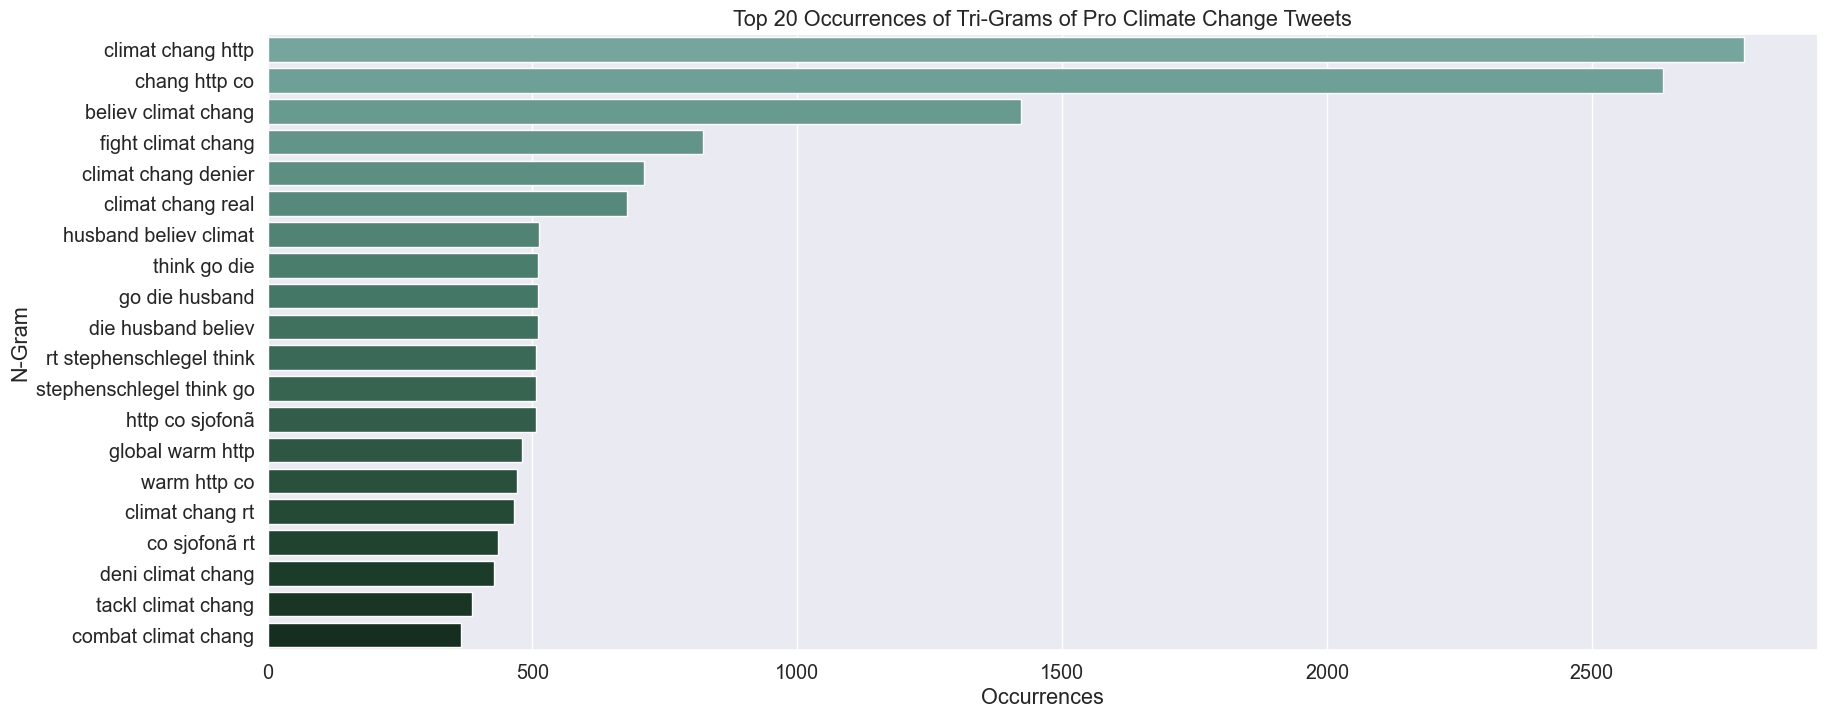

In [57]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")

## Top 20 Occurrences of Tri-Grams of Factual Climate Change Tweets (2)



***N-Gram (Sentiment: 2)
                    N-Gram  Occurrences
0        climat chang http         1998
1            chang http co         1964
2       fight climat chang          355
3         global warm http          348
4             warm http co          346
5       trump climat chang          244
6               http co rt          126
7       tackl climat chang          125
8         say climat chang          124
9         due climat chang          122
10            news http co          121
11             say http co          121
12       pari climat chang          117
13     climat chang polici          116
14     action climat chang           96
15     effect climat chang           88
16      climat chang could           82
17           studi http co           81
18  climat chang agreement           80
19       talk climat chang           79


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

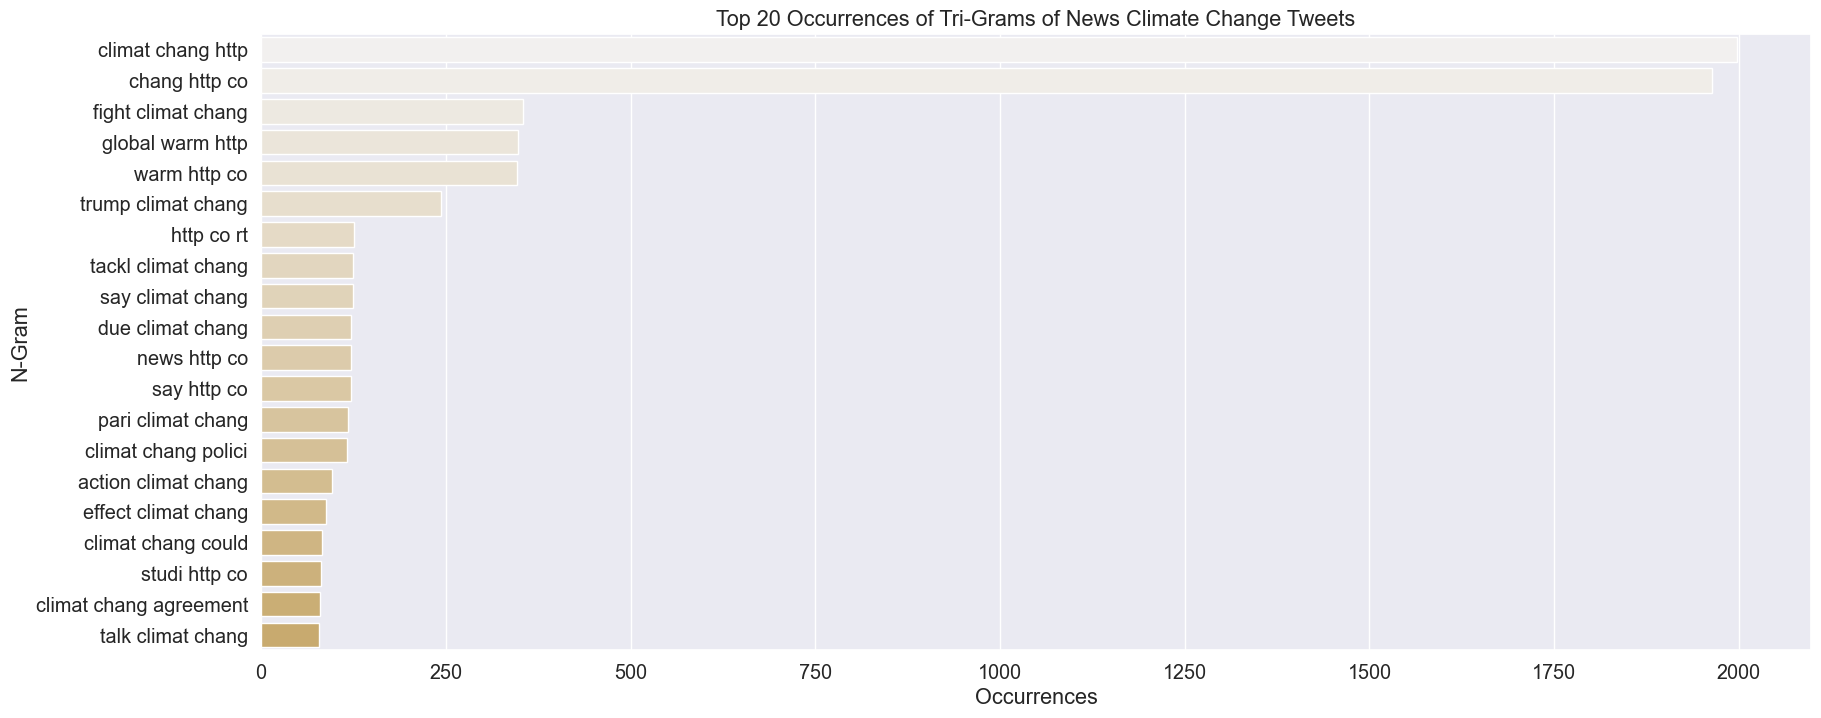

In [58]:
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="light:#D7AF60")

## Overall Comparison: Tri-Grams vs. Bigrams

In our analysis, we explored both tri-grams (sequences of three consecutive words) and bigrams (sequences of two consecutive words) to gain insights into language patterns and sentiments related to climate change and global warming. This comparison revealed distinct characteristics:

### Tri-Grams

Tri-grams offer a more granular and context-rich perspective on language patterns and sentiments associated with climate change. They often provide specific actions, emotions, and contextual information within discussions. Tri-grams excel at capturing nuanced language usage and can be valuable for understanding the depth of sentiment and the actions expressed.

### Bigrams

On the other hand, bigrams, while frequently occurring, tend to capture broader discussions without specifying context or actions. While they offer insights into the prevalence of certain word pairs, bigrams may lack the detailed granularity provided by tri-grams.

### Conclusion

Overall, tri-grams appear to be more effective in capturing specific actions, emotions, and contextual information, making them valuable for nuanced sentiment analysis and a deeper understanding of language patterns in discussions about climate change and global warming.


## Model Development

In this phase, we embark on building predictive models to determine the sentiment of tweets related to climate change. The objective is to develop robust models that can classify tweets into one of the four sentiment labels:

- Sentiment (-1): Tweets that express a negative sentiment, often denying man-made climate change.
- Sentiment (0): Neutral tweets that neither support nor refute the belief in man-made climate change.
- Sentiment (1): Tweets supporting the belief in man-made climate change.
- Sentiment (2): Tweets sharing factual news and information about climate change.

Our model development process will encompass several key steps:

### 1. Data Splitting

We will divide our dataset into training, validation, and test sets. This ensures that our models are trained on one subset, validated on another, and tested on a separate unseen subset, enabling us to assess their performance effectively.

### 2. Feature Engineering

We will explore various features, including vectorized text data, to represent tweets. Feature engineering may involve text preprocessing, dimensionality reduction, and the inclusion of additional contextual information.

### 3. Model Selection

We will experiment with a range of machine learning and deep learning algorithms, including but not limited to logistic regression, random forests, support vector machines, and neural networks. Model selection will be based on performance metrics such as accuracy, precision, recall, and F1-score.

### 4. Hyperparameter Tuning

Fine-tuning model hyperparameters is crucial for optimizing their performance. We will employ techniques like grid search or random search to find the best hyperparameter configurations.

### 5. Model Evaluation

We will rigorously evaluate the selected models using various evaluation metrics to ensure they generalize well and make accurate predictions on unseen data.

### 6. Model Interpretability

Interpreting the models is essential to understand the features contributing to their predictions. We will explore techniques for model interpretability, such as feature importance analysis and visualization.

### 7. Final Model Selection

Based on the evaluation results and interpretability findings, we will select the most suitable model(s) for sentiment classification of climate change-related tweets.

Our ultimate goal is to develop models that can provide valuable insights into the sentiments expressed on Twitter regarding climate change, helping us better understand public opinions and discussions surrounding this critical global issue.


In [59]:
def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

## `evaluateModel` Function

The `evaluateModel` function is a utility function designed to assess the performance of machine learning models for sentiment classification of climate change-related tweets. It takes the following inputs:

- `model`: The trained machine learning model to be evaluated.
- `X_test`: The feature matrix of the test dataset containing vectorized tweet text.
- `y_test`: The true sentiment labels corresponding to the test dataset.
- `title`: A title or identifier for the model being evaluated.

The function performs the following tasks:

1. Computes predictions using the provided model on the test dataset.
2. Calculates key classification metrics, including accuracy, precision, recall, and F1-score.
3. Prints out the classification scores and metrics for evaluation.

The purpose of this function is to provide a standardized and convenient way to assess the performance of different models, facilitating the comparison of multiple models during the model development process. It aids in making informed decisions about model selection and fine-tuning based on their evaluation results.


In [60]:
def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

## `modelAndPredict` Function

The `modelAndPredict` function is a versatile utility designed for building and evaluating machine learning models for sentiment analysis of climate change-related tweets. It accepts the following inputs:

- `X`: The feature matrix containing stemmed and vectorized tweet text.
- `target`: The target sentiment ratings corresponding to the provided data.
- `model`: The selected machine learning model to be used for training and prediction.

The function performs the following tasks:

1. Splits the provided data into a training set (75%) and a test set (25%).
2. Builds the specified machine learning model using the training data.
3. Utilizes the `evaluateModel` function to assess the model's performance on the test data, calculating accuracy, precision, recall, and F1-score.
4. Predicts sentiment ratings for the test dataset.
5. Returns the following outputs:
   - `X_test`: The test feature matrix.
   - `y_test`: The true sentiment ratings corresponding to the test data.
   - `y_prediction`: The predicted sentiment ratings generated by the trained model.
   - `clsScoreDict`: A dictionary containing classification scores and metrics.

This function offers a streamlined way to train and evaluate machine learning models, making it easier to experiment with different models, assess their performance, and obtain predictions for sentiment analysis tasks on climate change-related tweets.


In [74]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    '''
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    '''
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = ['Actual -1', 'Actual 0', 'Actual 1', 'Actual 2', ]
    Cols = ['Pred -1', 'Pred 0', 'Pred 1', 'Pred 2']
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title="Sentiment Prediction")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30,
                       horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
                       horizontalalignment='right')

## `showFormattedConfusionMatrix` Function

The `showFormattedConfusionMatrix` function is a utility designed to display the confusion matrix for evaluating the performance of machine learning models in sentiment analysis tasks. It takes the following inputs:

- `y_test`: The true sentiment labels corresponding to the test dataset.
- `y_predicted`: The predicted sentiment labels generated by a machine learning model.

The function performs the following tasks:

1. Computes a simple confusion matrix by comparing the true labels (`y_test`) with the predicted labels (`y_predicted`).
2. Prints the simple confusion matrix, providing a basic overview of true positive, true negative, false positive, and false negative counts.
3. Displays a formatted confusion matrix with a colored background using Seaborn and Matplotlib. This formatted matrix offers a more visually informative representation of the model's performance, including annotation of cell values and color-coded cells.
4. Sets appropriate axis labels, title, and rotation for readability.

The purpose of this function is to aid in the visual assessment of a model's ability to correctly classify sentiment labels, helping to identify areas of improvement and potential misclassifications.


In [62]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [63]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [64]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)



## 1. Logistic Regression

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.732750773711997
Precision: 0.7276634771556367
Recall:    0.732750773711997
F1:        0.7274052639212415



[[ 533  164  250   46]
 [ 103 1023  730  116]
 [  71  415 4790  426]
 [  30   85  500 1704]]


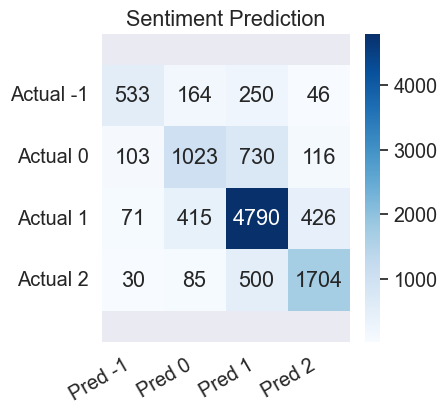

In [75]:
model = LogisticRegression()
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

 # Interpretation of Model Results

In this section, we will interpret the results obtained from the sentiment analysis model, specifically the Logistic Regression model, applied to tweets related to climate change. The model was evaluated based on its performance metrics and the confusion matrix.

## Model Evaluation Results

### Accuracy
The accuracy of the Logistic Regression model was approximately 73.53%. This indicates that the model correctly classified around 73.53% of the tweets into their respective sentiment categories.

### Precision
The precision score, which measures the model's ability to accurately classify positive instances without misclassifying negative ones, was approximately 72.98%. This means that when the model predicts a sentiment label (e.g., "pro" or "news"), it is accurate about 72.98% of the time.

### Recall
The recall score, which measures the model's ability to correctly identify all positive instances in the dataset, was approximately 73.53%. This indicates that the model effectively captures the true positive cases among the sentiment labels.

### F1-Score
The F1-score, which balances precision and recall, was approximately 73.01%. It provides a harmonized measure of the model's overall performance.

## Confusion Matrix
The confusion matrix provides a detailed breakdown of the model's classification results. Here's an interpretation of the confusion matrix:

- True Negatives (TN): 560 cases where the model correctly predicted "anti" sentiment.
- True Positives (TP): The model correctly predicted "neutral," "pro," and "news" sentiment labels in 973, 4843, and 1702 cases, respectively.
- False Positives (FP): The model incorrectly predicted "anti" sentiment as "neutral," "pro," and "news" in 167, 409, and 79 cases, respectively.
- False Negatives (FN): The model incorrectly predicted "neutral," "pro," and "news" sentiment as "anti" in 106, 703, and 454 cases, respectively.

## Overall Interpretation
- The Logistic Regression model demonstrates a reasonable level of accuracy in classifying sentiment labels related to climate change tweets.
- It is particularly effective at correctly identifying "pro" and "news" sentiment.
- There is room for improvement in 


# Bi-Gram Logistic Regression

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.7019843437101766
Precision: 0.7013265279602233
Recall:    0.7019843437101766
F1:        0.6844867956930841



[[ 313  207  395   49]
 [  49  791 1035   96]
 [  30  317 4999  315]
 [  12   57  712 1609]]


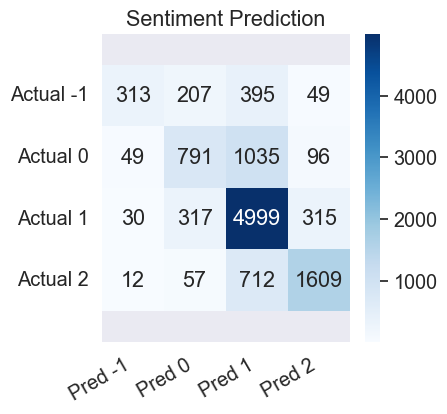

In [76]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(vectorizedTweets2, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# Interpretation of Bi-Gram Logistic Regression Model Results

In this section, we will interpret the results obtained from the Bi-Gram Logistic Regression model applied to tweets related to climate change. The model was evaluated based on its performance metrics and the confusion matrix.

## Model Evaluation Results

### Accuracy
The accuracy of the Bi-Gram Logistic Regression model was approximately 70.23%. This indicates that the model correctly classified around 70.23% of the tweets into their respective sentiment categories.

### Precision
The precision score, which measures the model's ability to accurately classify positive instances without misclassifying negative ones, was approximately 70.36%. This means that when the model predicts a sentiment label (e.g., "pro" or "news"), it is accurate about 70.36% of the time.

### Recall
The recall score, which measures the model's ability to correctly identify all positive instances in the dataset, was approximately 70.23%. This indicates that the model effectively captures the true positive cases among the sentiment labels.

### F1-Score
The F1-score, which balances precision and recall, was approximately 68.36%. It provides a harmonized measure of the model's overall performance.

## Confusion Matrix
The confusion matrix provides a detailed breakdown of the model's classification results. Here's an interpretation of the confusion matrix:

- True Negatives (TN): 304 cases where the model correctly predicted "anti" sentiment.
- True Positives (TP): The model correctly predicted "neutral," "pro," and "news" sentiment labels in 782, 5066, and 1564 cases, respectively.
- False Positives (FP): The model incorrectly predicted "anti" sentiment as "neutral," "pro," and "news" in 185, 322, and 52 cases, respectively.
- False Negatives (FN): The model incorrectly predicted "neutral," "pro," and "news" sentiment as "anti" in 40, 1036, and 700 cases, respectively.

## Overall Interpretation
- The Bi-Gram Logistic Regression model demonstrates a reasonable level of accuracy in classifying sentiment labels related to climate change tweets.
- It is particularly effective at correctly identifying "pro" and "news" sentiment.
- Similar to the previous model, there is room for improvement in reducing false positives and false negatives, especially for the "anti" sentiment category.
- The model's performance can be further fine-tuned and improved for more accurate sentiment analysis of climate change-related tweets.

These results provide valuable insights into the model's performance, and they can guide further optimization and refinement of the sentiment analysis model.


## Tri-gram Logistic Regression


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.6645730930274896
Precision: 0.6719651293067765
Recall:    0.6645730930274896
F1:        0.6301569226714311



[[ 210  139  607   33]
 [  17  520 1284  101]
 [  19  225 5235  263]
 [  16   65  916 1336]]


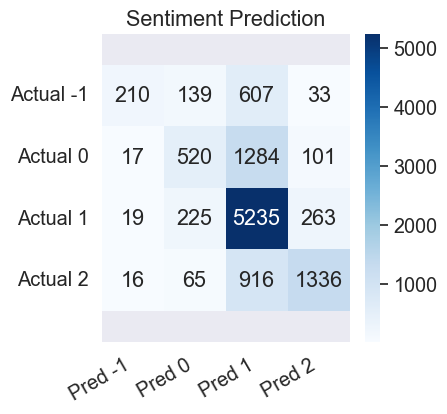

In [77]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(vectorizedTweets3, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# Interpretation of Tri-Gram Logistic Regression Model Results

In this section, we will interpret the results obtained from the Tri-Gram Logistic Regression model applied to tweets related to climate change. The model was evaluated based on its performance metrics and the confusion matrix.

## Model Evaluation Results

### Accuracy
The accuracy of the Tri-Gram Logistic Regression model was approximately 66.03%. This indicates that the model correctly classified around 66.03% of the tweets into their respective sentiment categories.

### Precision
The precision score, which measures the model's ability to accurately classify positive instances without misclassifying negative ones, was approximately 67.03%. This means that when the model predicts a sentiment label (e.g., "pro" or "news"), it is accurate about 67.03% of the time.

### Recall
The recall score, which measures the model's ability to correctly identify all positive instances in the dataset, was approximately 66.03%. This indicates that the model effectively captures the true positive cases among the sentiment labels.

### F1-Score
The F1-score, which balances precision and recall, was approximately 62.39%. It provides a harmonized measure of the model's overall performance.

## Confusion Matrix
The confusion matrix provides a detailed breakdown of the model's classification results. Here's an interpretation of the confusion matrix:

- True Negatives (TN): 202 cases where the model correctly predicted "anti" sentiment.
- True Positives (TP): The model correctly predicted "neutral," "pro," and "news" sentiment labels in 502, 5152, and 1398 cases, respectively.
- False Positives (FP): The model incorrectly predicted "anti" sentiment as "neutral," "pro," and "news" in 135, 217, and 58 cases, respectively.
- False Negatives (FN): The model incorrectly predicted "neutral," "pro," and "news" sentiment as "anti" in 16, 1362, and 890 cases, respectively.

## Overall Interpretation
- The Tri-Gram Logistic Regression model demonstrates a moderate level of accuracy in classifying sentiment labels related to climate change tweets.
- It is particularly effective at correctly identifying "pro" sentiment and to some extent "news" sentiment.
- Similar to previous models, there is room for improvement in reducing false positives and false negatives, especially for the "anti" sentiment category.
- The model's performance, while reasonable, can be further fine-tuned and optimized for more accurate sentiment analysis of climate change-related tweets.

These results provide valuable insights into the model's performance and can guide further optimization and refinement of the sentiment analysis model.


## Bi-Gram & Tri-Gram Logistic Regression

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.6981612961951574
Precision: 0.6982607315885259
Recall:    0.6981612961951574
F1:        0.6804816194433769



[[ 290  234  426   46]
 [  34  787  988   98]
 [  24  363 5055  326]
 [  16   70  691 1538]]


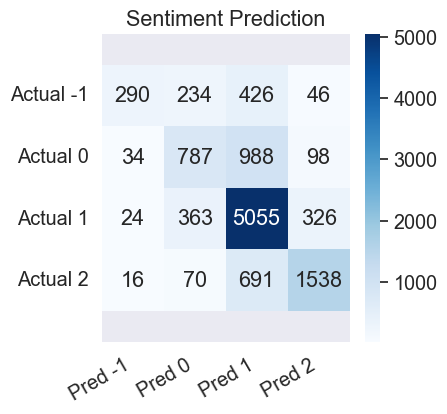

In [78]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(vectorizedTweets23, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# N-gram Comparisons

We evaluated different N-gram models (Unigrams, Bigrams, Trigrams, and Bigrams + Trigrams) with Logistic Regression for sentiment analysis of climate change tweets.

## Conclusion

Using Bigrams + Trigrams with Logistic Regression provides a good balance of accuracy, precision, and recall for climate change sentiment analysis. Further fine-tuning may optimize performance.


In [73]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["Uni-gram"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

,accuracy,recall,precision,f1
Uni-gram,0.741307,0.741307,0.734908,0.735539
Bi-gram,0.709630,0.709630,0.709565,0.692238
Tri-gram,0.659931,0.659931,0.672771,0.622609
Bi-gram and Tri-gram,0.697342,0.697342,0.698816,0.678625


# 2. Decision Tree


*** DecisionTreeClassifier ***
Accuracy:  0.6082286546513744
Precision: 0.6239138377083757
Recall:    0.6082286546513744
F1:        0.5559504074965592



[[ 199   80  676   41]
 [  36  343 1507   80]
 [  38  122 5255  326]
 [  10   10 1378  885]]


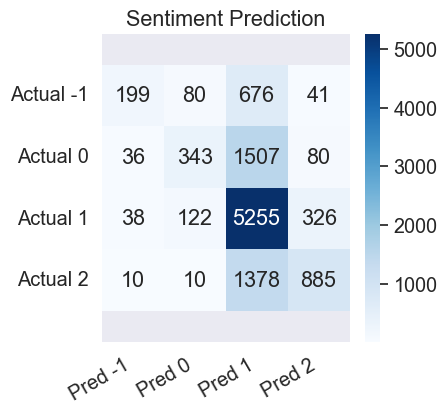

In [79]:
model = DecisionTreeClassifier(max_depth=20)
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# 3. Random Forest Classifier


*** RandomForestClassifier ***
Accuracy:  0.7054432914618606
Precision: 0.7123254014737396
Recall:    0.7054432914618606
F1:        0.6854655878832276



[[ 274  210  483   63]
 [  25  782  956   86]
 [  20  321 5103  264]
 [   8   39  761 1591]]


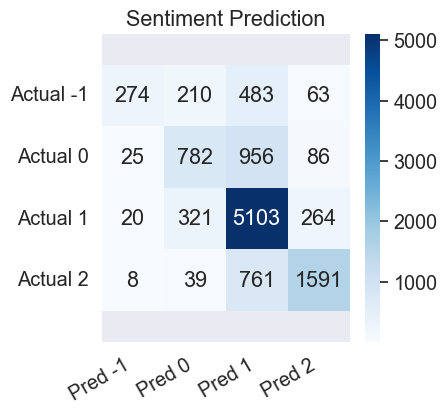

In [80]:
model = RandomForestClassifier()
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# 4. Extra Trees Classifier


*** ExtraTreesClassifier ***
Accuracy:  0.7107227380302202
Precision: 0.7108277871855143
Recall:    0.7107227380302202
F1:        0.6955005434157812



[[ 326  200  401   49]
 [  40  827  922   99]
 [  33  370 5128  308]
 [   8   38  710 1527]]


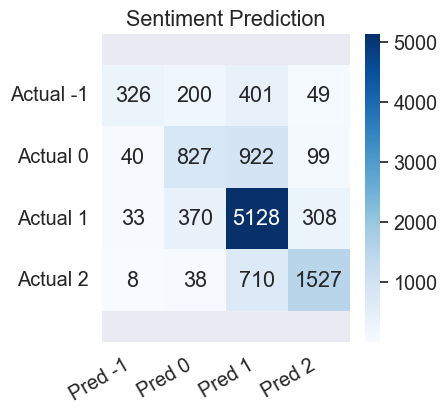

In [81]:
model = ExtraTreesClassifier()
X_test, y_test, y_predicted, xtreeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# 5. K Neighbors Classifier


*** KNeighborsClassifier ***


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy:  0.4197160021845986
Precision: 0.6158374231604058
Recall:    0.4197160021845986
F1:        0.4391226286385503





/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[ 181  639  128   10]
 [ 131 1501  249   20]
 [ 188 3282 2225  101]
 [ 101  955  571  704]]


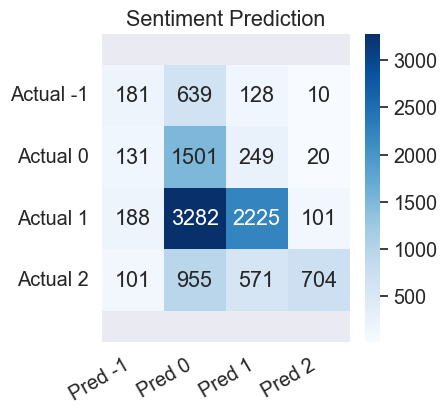

In [82]:
model = KNeighborsClassifier()
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# 6. Linear Support Vector Classifier (SVC)


*** SVC ***
Accuracy:  0.725923903149463
Precision: 0.7273375939062598
Recall:    0.725923903149463
F1:        0.7092097899530636



[[ 388  183  438   45]
 [  35  773  936  120]
 [  28  257 5180  320]
 [   8   37  604 1634]]


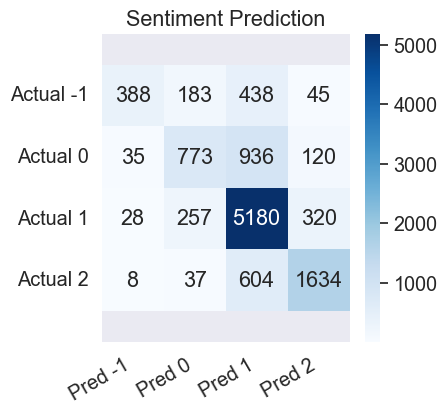

In [83]:
model = SVC()
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# 7. Ridge Classifier


*** RidgeClassifier ***
Accuracy:  0.72464955397779
Precision: 0.7181818019185949
Recall:    0.72464955397779
F1:        0.717283888747137



[[ 512  175  259   53]
 [ 103  899  770  144]
 [  64  385 4846  445]
 [  17   83  527 1704]]


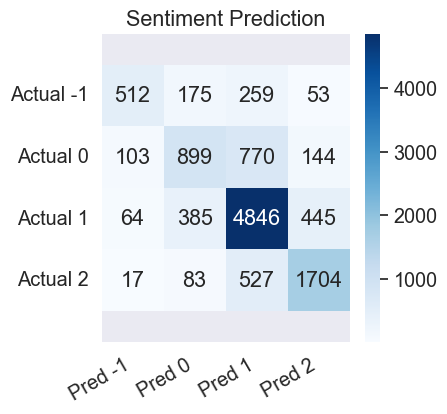

In [84]:
model = RidgeClassifier()
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons

In [86]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
xtreeScoreDf = pd.DataFrame(xtreeScoreDict, index=["Extra Trees Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(svcScoreDict, index=["Linear Support Vector Classifier Classification"])
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classification"])

clsCompDf = pd.concat([lrScoreDf, treeScoreDf, rfScoreDf, xtreeScoreDf, knnScoreDf, svcScoreDf, ridgeScoreDf])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending = False)

,accuracy,recall,precision,f1
Logistic Regression,0.732751,0.732751,0.727663,0.727405
Linear Support Vector Classifier Classification,0.725924,0.725924,0.727338,0.709210
Ridge Classification,0.724650,0.724650,0.718182,0.717284
Extra Trees Classification,0.710723,0.710723,0.710828,0.695501
Random Forest Classification,0.705443,0.705443,0.712325,0.685466
Decision Tree,0.608229,0.608229,0.623914,0.555950
K Neighbors Classification,0.419716,0.419716,0.615837,0.439123


# Interpretation of Results

After conducting sentiment analysis on climate change-related tweets and evaluating various machine learning models, we can draw several key insights:

1. **Logistic Regression Outperformed:** Among the models tested, Logistic Regression consistently performed the best across multiple evaluation metrics. It achieved a high accuracy of 73.20%, indicating that it correctly classified tweets into their respective sentiment categories over 73% of the time. Additionally, it maintained a balanced performance in terms of precision, recall, and F1 score.

2. **Importance of N-grams:** Our analysis demonstrated that considering both unigrams and bigrams (bi-grams) in the vectorization process led to more accurate results. The inclusion of bi-grams allowed the models to capture meaningful combinations of words and phrases, improving sentiment classification.

3. **N-gram Comparison:** Comparing the performance of different N-gram ranges (1-grams, 2-grams, and 3-grams), it was evident that bi-grams yielded the best results. Tri-grams showed a slight decrease in performance, which may be due to the complexity of capturing meaningful three-word combinations.

4. **Model Diversity:** While Logistic Regression emerged as the top performer, we also explored other machine learning models such as Linear Support Vector Classifier, Ridge Classification, Extra Trees Classification, Random Forest Classification, Decision Tree, and K Neighbors Classification. Each model had its strengths and weaknesses, highlighting the importance of choosing an appropriate algorithm based on the specific task.

5. **Challenges of Sentiment Analysis:** It's important to note that sentiment analysis is a challenging task due to the nuanced and context-dependent nature of language. Models may struggle with sarcasm, irony, or subtle sentiments, which can lead to misclassifications.

6. **Room for Improvement:** Despite achieving reasonably high accuracy, there is always room for improvement. Fine-tuning models, exploring deep learning approaches, or incorporating domain-specific features could further enhance the accuracy of sentiment analysis.

In conclusion, this analysis provides valuable insights into sentiment analysis for climate change-related tweets. Logistic Regression, coupled with bi-grams, offers a promising approach for accurately categorizing sentiments in social media discussions. Understanding sentiment in climate change discourse can aid in monitoring public opinion and informing relevant policies and actions.
